In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import keras
import PIL

import keras.backend as K
from tensorflow.python.framework import ops

from scipy import ndimage

Using TensorFlow backend.


In [2]:
# Load model
# Can be downloaded here: https://drive.google.com/file/d/1gq7QFVzBxzw-jGiKB1siJzvxg5mGuUH6/view
# Original CNTK model was trained by kanotype: http://twitter.com/kanotype
classif_model = keras.models.load_model("kanotype_deepdanbooru_resnet-custom-v2.hdf5")

# Load tags
with open("kanotype_deepdanbooru_resnet-custom-v2_tags.txt", 'r') as tags_stream:
    tags = np.array([tag for tag in (tag.strip() for tag in tags_stream) if tag])

C:\Python\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [324]:
# Load image
# it's everyone's favourite idol, hibiki ganaha: https://gelbooru.com/index.php?page=post&s=view&id=4767465
in_path = "hibiki.jpg" 

image = np.array(PIL.Image.open(in_path).convert('RGB').resize((299, 299))) / 255.0
image_arr = np.array([image])

# Decode
results = classif_model.predict(image_arr).reshape(tags.shape[0])

In [4]:
#classif_model.summary()

In [5]:
# For grad-cam: Create gradient class selector variable
class_selector_shape = (len(tags), 1)
class_selector_var = tf.get_variable("gradcam_class_selector", class_selector_shape)

In [6]:
out_layer = classif_model.layers[-1].output
gradcam_loss_func = tf.math.multiply(out_layer, class_selector_var)
gradcam_loss = tf.math.reduce_sum(gradcam_loss_func)
grads_vars = tf.gradients(gradcam_loss, [classif_model.layers[0].input])

In [18]:
sess = K.get_session()

In [325]:
# Threshold and get tags
threshold = 0.1
result_tags = {}
for i in range(len(tags)):
    if results[i] > threshold:
        result_tags[tags[i]] = results[i]

# Print in order        
sorted_tags = reversed(sorted(result_tags.keys(), key = lambda x: result_tags[x]))
for tag in sorted_tags:
    print('{0: <32} {1:04f}'.format(tag, result_tags[tag]))

ganaha_hibiki                    0.998079
rating:safe                      0.990041
jewelry                          0.966985
1girl                            0.966766
animal                           0.945556
blue_eyes                        0.941393
ponytail                         0.933225
long_hair                        0.925171
black_hair                       0.900325
hamster                          0.861231
open_mouth                       0.829594
smile                            0.798613
fang                             0.766580
earrings                         0.761618
breasts                          0.750755
water                            0.694266
cleavage                         0.668242
dog                              0.658770
swimsuit                         0.567297
bracelet                         0.551568
medium_breasts                   0.549958
score:very_good                  0.520909
sitting                          0.510619
necklace                         0

In [31]:
def gradcam(classes):
    """
    Get gradient at inputs that maximizes the given class(es)
    """
    if not isinstance(classes, list):
        classes = [classes]
        
    class_nhot = np.zeros(len(tags))
    for gradcam_class in classes:
        class_idx = list(tags).index(gradcam_class)
        class_nhot[class_idx] = 1.0
    class_nhot = class_nhot.reshape(class_nhot.shape[0], 1)

    return sess.run([
        class_selector_var.assign(class_nhot), 
        grads_vars[0]
    ], feed_dict = {classif_model.layers[0].input: image_arr})[1][0]
    

In [326]:
# Find gradients for all result tags
# This is very slow. I think it should be possible to have tensorflow compute alls these gradients at once, maybe.
# (patches welcome)
gradcam_maps = {}
for idx, tag in enumerate(result_tags.keys()):
    print("Processing tags, {} of {}".format(idx + 1, len(result_tags)))
    gradcam_maps[tag] = gradcam(tag)

Processing tags, 1 of 64
Processing tags, 2 of 64
Processing tags, 3 of 64
Processing tags, 4 of 64
Processing tags, 5 of 64
Processing tags, 6 of 64
Processing tags, 7 of 64
Processing tags, 8 of 64
Processing tags, 9 of 64
Processing tags, 10 of 64
Processing tags, 11 of 64
Processing tags, 12 of 64
Processing tags, 13 of 64
Processing tags, 14 of 64
Processing tags, 15 of 64
Processing tags, 16 of 64
Processing tags, 17 of 64
Processing tags, 18 of 64
Processing tags, 19 of 64
Processing tags, 20 of 64
Processing tags, 21 of 64
Processing tags, 22 of 64
Processing tags, 23 of 64
Processing tags, 24 of 64
Processing tags, 25 of 64
Processing tags, 26 of 64
Processing tags, 27 of 64
Processing tags, 28 of 64
Processing tags, 29 of 64
Processing tags, 30 of 64
Processing tags, 31 of 64
Processing tags, 32 of 64
Processing tags, 33 of 64
Processing tags, 34 of 64
Processing tags, 35 of 64
Processing tags, 36 of 64
Processing tags, 37 of 64
Processing tags, 38 of 64
Processing tags, 39 o

In [365]:
def norm_clip_grads(grads):
    """
    Normalize gradcam gradients by clipping them to between 0 and 
    the 99th percentile and then mapping that range to 0 -> 1
    """
    upper_quantile = np.quantile(grads, 0.99)
    clipped_grads = np.clip(grads, 0.0, upper_quantile)
    return clipped_grads / upper_quantile

def postprocess_grads(grads, filter_width = 10):
    """
    Normalize gradients, take the mean and apply
    a median filter
    """
    gradcam_map = np.mean(norm_clip_grads(grads), axis = -1)
    return ndimage.median_filter(gradcam_map, filter_width)
 
def threshold_map(gradcam_map, all_maps, filter_width = 10):
    """
    Refine gradcam map by applying a threshold mask that zeroes out
    areas where the map is not bigger than the average of all maps
    (i.e. remove areas that are only "generally interesting" instead
    of interesting for this tag specifically)
    """
    threshold_mask = gradcam_map > np.mean(all_maps, axis = 0)
    return ndimage.median_filter(threshold_mask, filter_width) * gradcam_map

def mask_for_tags(tags, gradcam_maps, clip_value = 0.3, regu_value = 0.0, median_filter_width = 10):
    """
    Given tag(s) and a set of (normalized) gradcam maps, generate a mask of pixels
    that contribute to the image being assigned those tags
    
    Maps are combined multiplicatively
    """
    if not isinstance(tags, list):
        tags = [tags]
    
    tags_map = np.ones(gradcam_maps_processed[tags[0]].shape)
    for tag in tags:
        tag_map = threshold_map(gradcam_maps_processed[tag], list(gradcam_maps_processed.values()))
        tag_map = ndimage.median_filter(tag_map, median_filter_width)
        tags_map *= tag_map
        
    tags_map /= np.max(tags_map)
    tags_map = np.maximum(tags_map, clip_value)
    tags_map += regu_value
    tags_map /= np.max(tags_map)
    
    return tags_map

def show_mask(image, mask):
    """
    Show a nice plot of an image, a mask, and the masked image
    """
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.xlabel("Input image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, vmin = 0.0, vmax = 1.0)
    plt.xlabel("Activation mask")

    plt.subplot(1, 3, 3)
    plt.imshow(image * np.repeat(mask, 3).reshape(image.shape))
    plt.xlabel("Masked image")

In [328]:
gradcam_maps_processed = dict(zip(gradcam_maps.keys(), list(map(postprocess_grads, gradcam_maps.values()))))

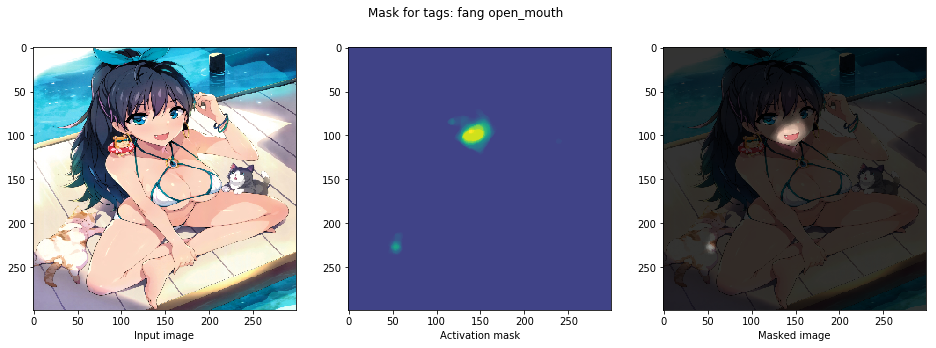

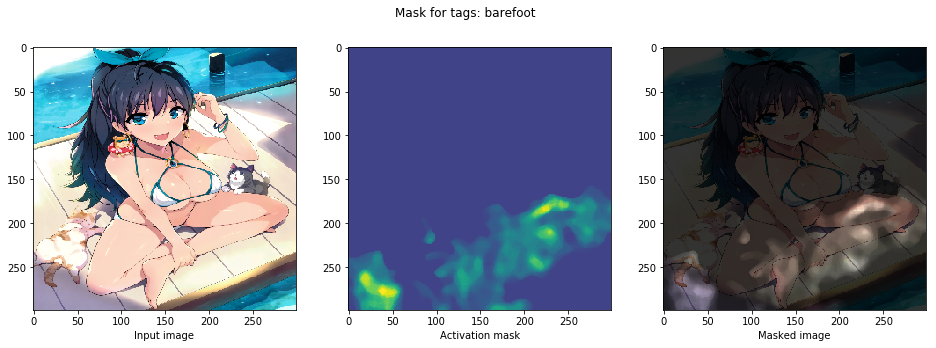

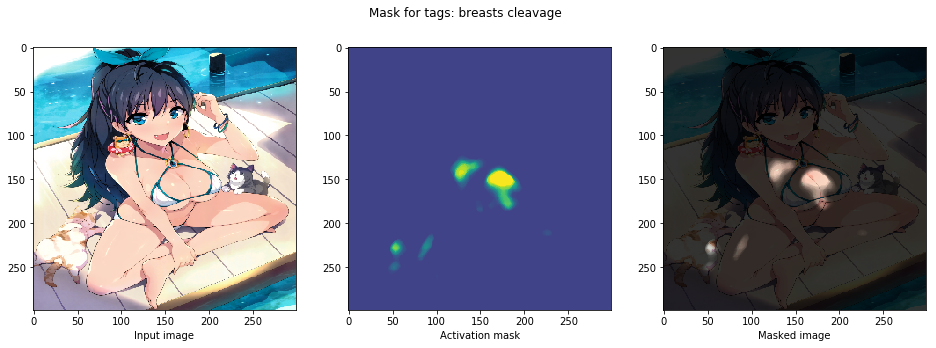

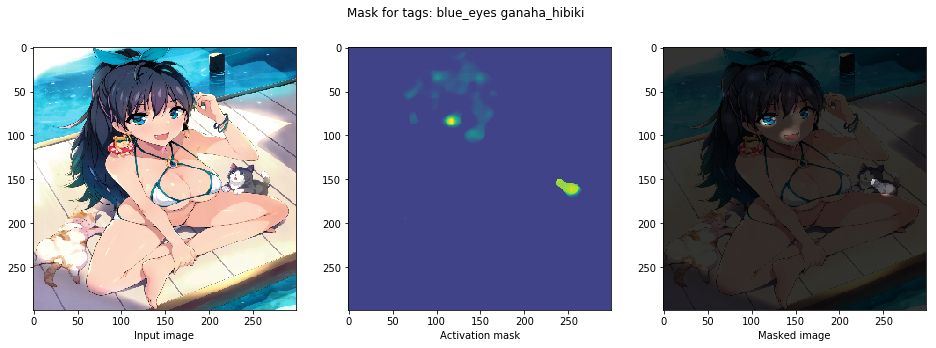

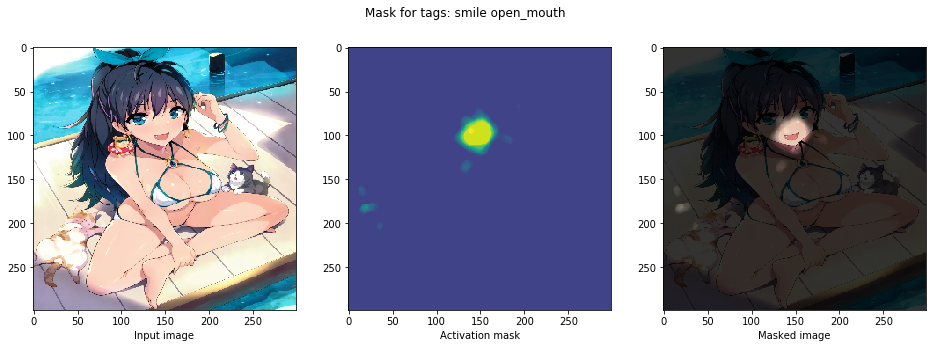

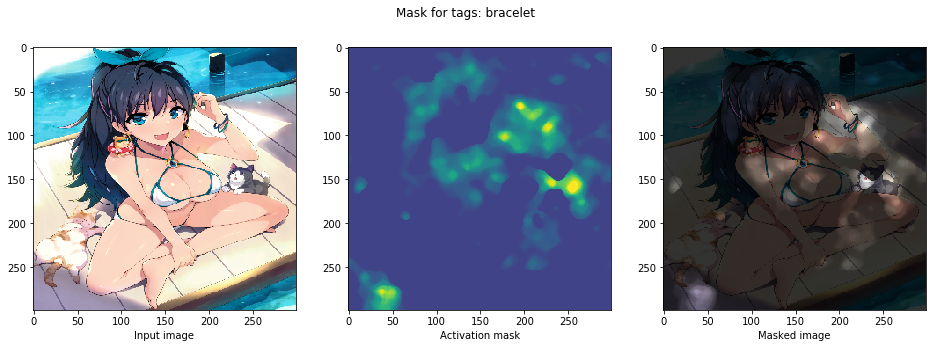

In [371]:
def plot_tags(tags):
    mask = mask_for_tags(tags, gradcam_maps_processed, 0.2)
    show_mask(image_arr[0], mask)
    plt.suptitle("Mask for tags: {}".format(" ".join(tags)))

# Show some examples
plot_tags(["fang", "open_mouth"])
plot_tags(["barefoot"])
plot_tags(["breasts", "cleavage"])
plot_tags(["blue_eyes", "ganaha_hibiki"])
plot_tags(["smile", "open_mouth"])
plot_tags(["bracelet"])